# Prediksi Harga Saham Britannia
_Britannia Stock Price Prediction_ pada market NIFTY 50

Sumber data: https://www.kaggle.com/rohanrao/nifty50-stock-market-data

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
from datetime import datetime

## 1. Impor Data

In [60]:
# Impor data
df_ori = pd.read_csv('BRITANNIA.csv')
df_ori.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BRITANNIA,EQ,703.25,705.0,759.50,705.0,758.0,756.90,741.01,7512,5.566488e+11,NaN,NaN,NaN
1,2000-01-04,BRITANNIA,EQ,756.90,710.0,770.00,710.0,740.0,754.55,742.52,8135,6.040391e+11,NaN,NaN,NaN
2,2000-01-05,BRITANNIA,EQ,754.55,755.0,759.00,705.0,740.0,735.30,739.92,6095,4.509784e+11,NaN,NaN,NaN
3,2000-01-06,BRITANNIA,EQ,735.30,740.0,794.15,740.0,770.0,785.65,788.83,19697,1.553756e+12,NaN,NaN,NaN
4,2000-01-07,BRITANNIA,EQ,785.65,808.0,848.50,798.0,848.5,848.50,827.53,33107,2.739708e+12,NaN,NaN,NaN


In [3]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5305 entries, 0 to 5304
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5305 non-null   object 
 1   Symbol              5305 non-null   object 
 2   Series              5305 non-null   object 
 3   Prev Close          5305 non-null   float64
 4   Open                5305 non-null   float64
 5   High                5305 non-null   float64
 6   Low                 5305 non-null   float64
 7   Last                5305 non-null   float64
 8   Close               5305 non-null   float64
 9   VWAP                5305 non-null   float64
 10  Volume              5305 non-null   int64  
 11  Turnover            5305 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4796 non-null   float64
 14  %Deliverble         4796 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.8

## 2. Data Cleaning

Kita akan spesifik menggunakan data Prev Close pada 2014

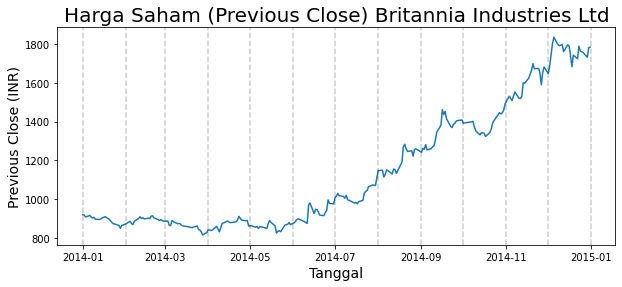

In [199]:
# Kita akan spesifik menggunakan data Prev Close pada 2014
df = df_ori['Prev Close']
df.index = pd.to_datetime(df_ori.Date)
awal = datetime(2014, 1, 1)
akhir = datetime(2014, 12, 31)
df = df[awal:akhir]
df = df.asfreq(freq='D')
df.interpolate(inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(df)
plt.title('Harga Saham (Previous Close) Britannia Industries Ltd', fontsize=20)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Previous Close (INR)', fontsize=14)
for month in range(1, 13):
    plt.axvline(pd.to_datetime('2014-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(pd.to_datetime('2015-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

## 3. Stationarity, Seasonality, orde AR, orde MA

### 3.1. Memecah komponen time series

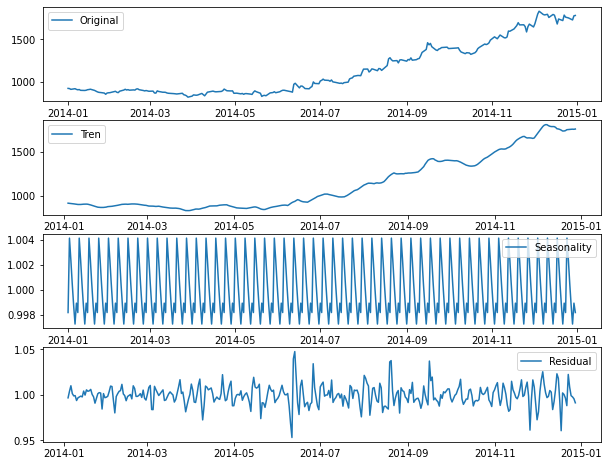

In [155]:
# Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(df, model='multiplicative')
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8))
ax[0].plot(df, label='Original')
ax[0].legend(loc='best')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='best')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='best')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='best')
plt.show()

Komponen tren berkontribusi besar serta nampak terdapat seasonality (kemungkinan merupakan efek merapikan time series, kita coba perhitungkan seasonality di akhir)

### 3.2. Stationarity (orde d)

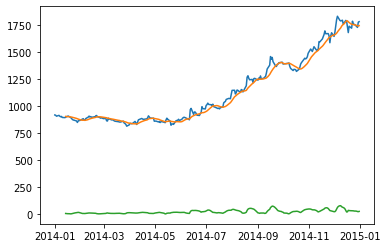

In [156]:
# Kita coba visualisasikan hasil rolling
rollingmean = df.rolling(14).mean()
rollingstd = df.rolling(14).std()
plt.plot(df, label='Original')
plt.plot(rollingmean, label='Mean')
plt.plot(rollingstd, label='std')
plt.show()

Tanpa Augmented Dickey Fuller (adfuller()) test kita bisa lihat data ini ngga stationary. Tapi kita coba adfuller untuk memastikan.

In [10]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

hasil_adfuller = adfuller(df.dropna())

print('ADF Statistik: %f' % hasil_adfuller[0])
print(f'p-value: {hasil_adfuller[1]}')

ADF Statistik: 1.049068
p-value: 0.994757618360792


p-value > 0.05, sekarang kita coba cari orde differencing untuk mencari stationarity

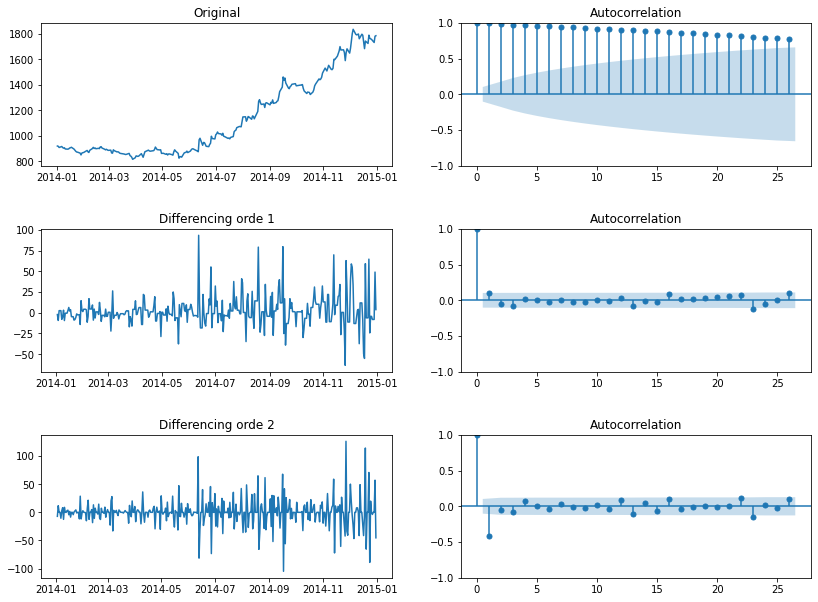

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
axes[0, 0].plot(df)
axes[0, 0].set_title('Original')
plot_acf(df, ax=axes[0, 1])

axes[1, 0].plot(df.diff())
axes[1, 0].set_title('Differencing orde 1')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('Differencing orde 2')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout(pad=3.0)

plt.show()

orde 1 differencing udah bikin time series (TS) stationary. Di autocorrelation plot nya juga udah ok, ngga terlalu cepet menuju negatif.

Autocorrelation plot untuk orde 2 terlalu cepet bikin nilai nya negatif.

Kita pakai d=1 dari hasil ini.

### 3.3. Menentukan AR lag awal

D:\equipments\miniconda\envs\iddzzz\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


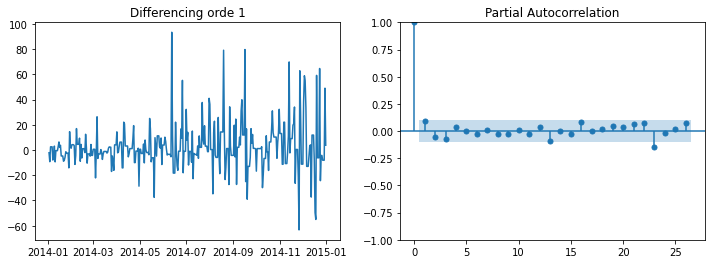

In [85]:
# PACF plot untuk menentukan p (komponen AR)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df.diff())
axes[0].set_title('Differencing orde 1')
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

Kita akan pakai p=1 untuk awal

### 3.4. Menentukan MA lag awal

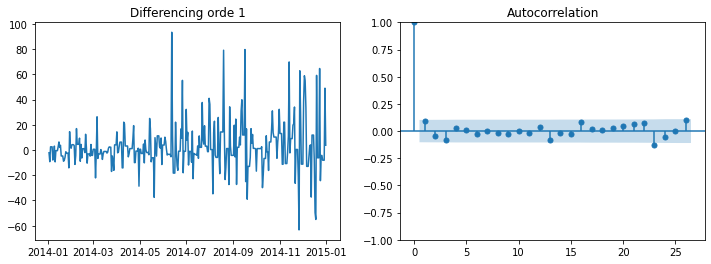

In [86]:
# ACF plot untuk menentukan q (komponen MA)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df.diff())
axes[0].set_title('Differencing orde 1')
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

Kita akan pakai q=1 untuk awal

## 4. Modelling

### 4.1. ARIMA model (baseline)

In [172]:
from datetime import timedelta

df_train = df[:'2014-11-30']
df_test = df['2014-12-01':]

# Model ARIMA (1, 1, 1) langsung ke df
model2 = ARIMA(df_train, order=(1, 1, 1))
model_fit = model2.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Prev Close   No. Observations:                  334
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1395.560
Date:                Sun, 13 Mar 2022   AIC                           2797.120
Time:                        17:41:59   BIC                           2808.544
Sample:                    01-01-2014   HQIC                          2801.675
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0391      0.507     -0.077      0.939      -1.034       0.956
ma.L1          0.1399      0.513      0.273      0.785      -0.865       1.145
sigma2       255.6808      8.624     29.648      0.000     238.779     272.583
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1060.82
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               8.38   Skew:                             1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nampak p-value tidak signifikan, kita sepertinya memang perlu tuning

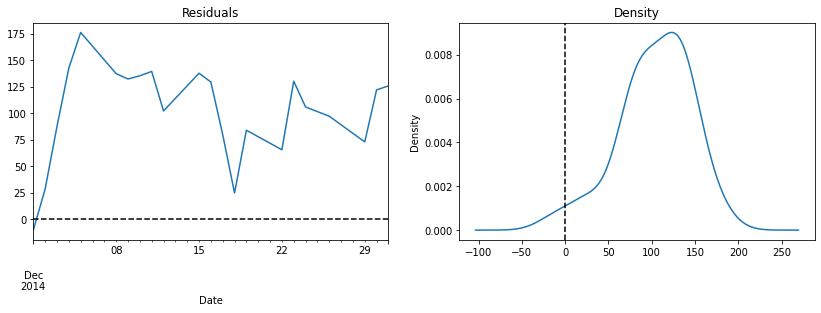

In [207]:
# Plot residual errors
pred = model_fit.predict(df_test.index[0], df_test.index[-1])
residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

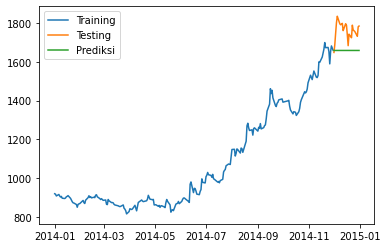

MAPE: 5.88%
RMSE: 111.58761793598286


In [174]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

## 5. Tuning

### 5.1. Coba d=2

In [175]:
# Model ARIMA (1, 2, 1) langsung ke df
model3 = ARIMA(df_train, order=(1, 2, 1)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Prev Close   No. Observations:                  334
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1391.147
Date:                Sun, 13 Mar 2022   AIC                           2788.295
Time:                        17:42:16   BIC                           2799.710
Sample:                    01-01-2014   HQIC                          2792.847
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0708      0.039      1.836      0.066      -0.005       0.146
ma.L1         -0.9872      0.009   -115.368      0.000      -1.004      -0.970
sigma2       252.6213      9.007     28.047      0.000     234.968     270.275
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               983.14
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               7.58   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-value nampak signifikan, mantap

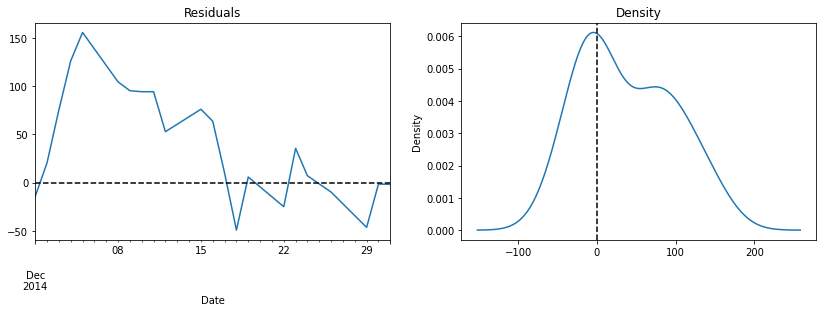

In [208]:
# Plot residual errors
pred = model3.predict(df_test.index[0], df_test.index[-1])
residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

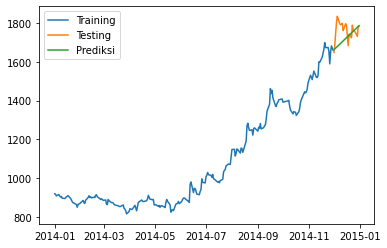

MAPE: 2.95%
RMSE: 69.112385737562


In [178]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

Arahnya keliatan pas

### 5.2. Tuning p, d, q pakai auto_arima

In [179]:
# Model ARIMA (p, d, q) menggunakan auto_arima()
import pmdarima as pm

model4 = pm.auto_arima(df_train, start_p=0, start_q=0,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=4, max_q=4,
                       m=1, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=False,
                       start_P=0,
                       D=0,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model4.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2792.096, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2791.913, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2791.752, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2796.499, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2793.653, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2793.524, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2795.210, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2795.130, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.851 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1392.876
Date:                Sun, 13 Mar 2022   AIC                           2791.752
Time:                        17:42:39   BIC                           2803.176
Sample:                             0   HQIC                          2796.307
                                - 334                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2138      1.083      2.045      0.041       0.092       4.335
ma.L1          0.0863      0.039      2.233      0.026       0.011       0.162
sigma2       251.5701      9.971     25.231      0.000     232.028     271.112
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1054.38
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.40   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

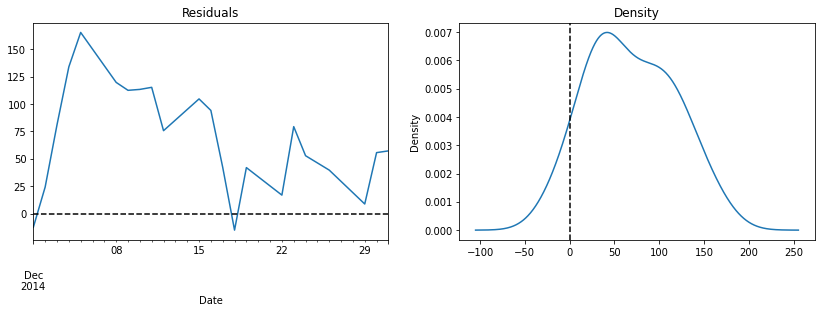

In [212]:
# Plot residual errors
pred = model4.predict(31)
pred = pd.Series(pred, index=df_test.index)

residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

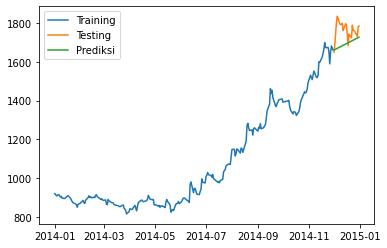

MAPE: 3.94%
RMSE: 83.1807611557012


In [213]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

### 5.3. Memperhitungkan Seasonality, pakai SARIMA

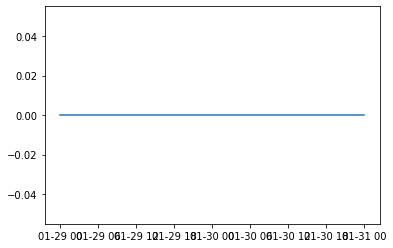

In [108]:
# Kita coba differencing 28
plt.plot(seasonal['2014-01-01':'2014-01-31'].diff(28))
plt.show()

In [185]:
model5 = pm.auto_arima(df_train, start_p=1, start_q=1,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=3, max_q=3,
                       m=28, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=True,
                       start_P=0,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model5.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[28]             : AIC=inf, Time=4.31 sec
 ARIMA(0,1,0)(0,1,0)[28]             : AIC=2710.988, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[28]             : AIC=2645.463, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[28]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(0,1,0)[28]             : AIC=2711.660, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[28]             : AIC=2627.001, Time=3.34 sec
 ARIMA(1,1,0)(2,1,1)[28]             : AIC=inf, Time=27.50 sec
 ARIMA(1,1,0)(1,1,1)[28]             : AIC=inf, Time=4.72 sec
 ARIMA(0,1,0)(2,1,0)[28]             : AIC=2629.854, Time=2.64 sec
 ARIMA(2,1,0)(2,1,0)[28]             : AIC=2626.613, Time=4.33 sec
 ARIMA(2,1,0)(1,1,0)[28]             : AIC=2647.326, Time=1.10 sec
 ARIMA(2,1,0)(2,1,1)[28]             : AIC=inf, Time=29.96 sec
 ARIMA(2,1,0)(1,1,1)[28]             : AIC=inf, Time=5.93 sec
 ARIMA(3,1,0)(2,1,0)[28]             : AIC=2628.610, Time=5.53 sec
 ARIMA(2,1,1)(2,1,0)[28]             : AIC=2628

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  334
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 28)   Log Likelihood               -1308.306
Date:                            Sun, 13 Mar 2022   AIC                           2626.613
Time:                                    17:49:25   BIC                           2645.215
Sample:                                         0   HQIC                          2634.053
                                            - 334                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1410      0.052      2.712      0.007       0.039       0.243
ar.L2         -0.0916      0.054     -1.706      0.088      -0.197       0.014
ar.S.L28      -0.6145      0.035    -17.690      0.000      -0.683      -0.546
ar.S.L56      -0.3077      0.054     -5.705      0.000      -0.413      -0.202
sigma2       298.8323     13.624     21.935      0.000     272.130     325.534
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               261.08
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               6.45   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best model:  ARIMA(2,1,0)(2,1,0)[28]

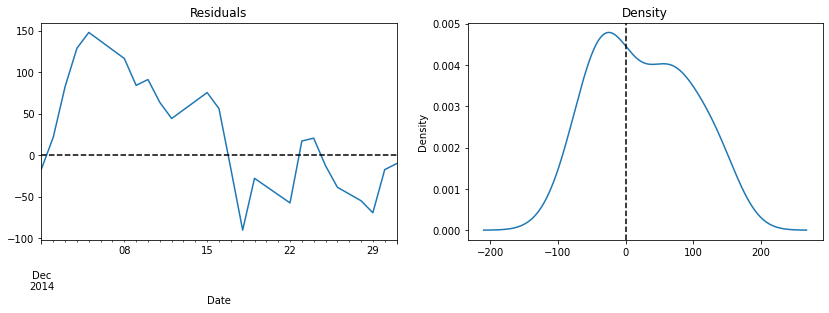

In [214]:
# Plot residual errors
pred = model5.predict(31)
pred = pd.Series(pred, index=df_test.index)

residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

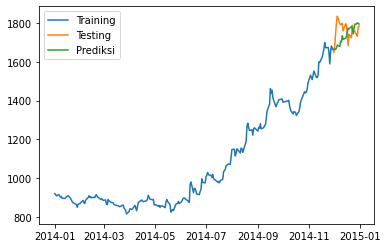

MAPE: 3.41%
RMSE: 72.14103983942847


In [215]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

Mantap

### 5.4. Rolling Forecast Origin ARIMA

Kita pakai model 3: ARIMA(1, 2, 1)

In [96]:
pred3 = df_test.copy()

for index in tqdm(df_test.index):
    train_data = df[:index - timedelta(days=1)]
    
    orderku = (1, 2, 1)
    model3 = ARIMA(train_data, order=orderku).fit()
    
    pred = model3.forecast()
    pred3[index] = pred

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00,  8.06it/s]


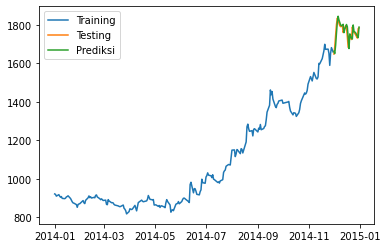

MAPE: 1.38%
RMSE: 31.355841628159368


In [184]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred3, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

### 5.5. Rangkuman Hasil Modelling

| Keterangan | Model | RMSE | MAPE |
| --- | --- | --- | --- |
| Baseline | ARIMA(1, 1, 1) | 111.6 | 5.88% |
| Tuning d manual | ARIMA(1, 2, 1) | 69.1 | 2.95% |
| Tuning menggunakan auto_arima | ARIMA(0, 1, 1) | 83.2 | 3.94% |
| Memperhitungkan seasonality pakai auto_arima | SARIMA(2, 1, 0)(2, 1, 0)[28] | 72.14 | 3.41% |
| Rolling forecast ARIMA | ARIMA(1, 2, 1) | 30.1 | 1.38% |

## 6. Prediksi

Pakai ARIMA(1, 2, 1)

<ipython-input-235-c8a217d2e387>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(df.append(jan)['2014-12-30':], label='Prediksi')


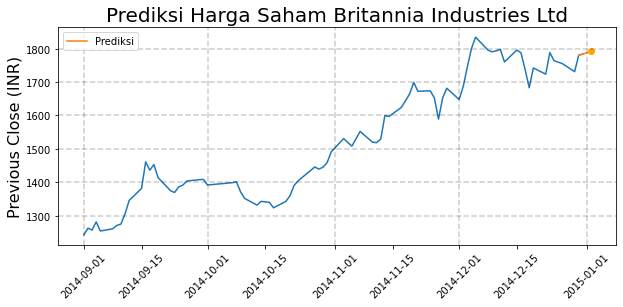

In [235]:
model_final = ARIMA(df, order=(1, 2, 1)).fit()
# Prediksi Januari Tanggal 1 - 7
jan = model_final.predict('2015-01-01', '2015-01-02')

fig = plt.figure(figsize=(10, 4))
plt.plot(df['2014-09-01':])
plt.plot(df.append(jan)['2014-12-30':], label='Prediksi')
plt.plot(datetime(2015, 1, 2), jan['2015-01-02'], marker='o', color='orange')
plt.xticks(rotation=45)
for month in range(9, 13):
    plt.axvline(pd.to_datetime('2014-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(pd.to_datetime('2015-01-01'), color='k', linestyle='--', alpha=0.2)
for num in range(1300, 1800 + 1, 100):
    plt.axhline(num, color='k', linestyle='--', alpha=0.2)
plt.title('Prediksi Harga Saham Britannia Industries Ltd', fontsize=20)
plt.ylabel('Previous Close (INR)', fontsize=16)
plt.legend(loc=2)
fig.savefig('prediksi.png', bbox_inches='tight')
plt.show()

## Kesimpulan

+ Model terbaik yang bisa digunakan untuk memprediksi adalah ARIMA(1, 2, 1) dengan error 2.95%
+ Harga saham Britannia Industries Ltd pada awal Januari 2015 diprediksi naik menuju nilai sekitar 1790 INR